# The Relationship between physiological metrics and weather

###### Jan 10, 2025

## Introduction
Have you ever wondered how the weather affects how well you sleep or recover from days of strain? Well, I did and I decided to look closer into my personal data collected through a Whoop wirst band that I have been wearing for the past 3 months. The whoop wrist band collects a wide range of different metrics related to sleep, stress and overall health. In this blog I'd like to explore the impact of other external factors such as the temperature. I decided to compare the health metrics with the average daily temperature of the city I live in with data sourced from the SMHI, Swedish Meteorological and Hydrological Institute. This is then compared to daily average temperature taken from SMHI. This blog is a brief personal exploration of my findings and should not be mistaken for a rigorous study.


## Data Collection

Before we dig into the data it is important to understand how the data is collected and what they mean. The data will consist of the following collected through Whoop:

- Sleep performance (%)
- Asleep duration (min)
- Recovery score %
- Resting heart rate (bpm)
- Heart rate variability 
- Resting heart rate (bpm)
- Day Strain

This has been collected through a smart wrist band that track health metrics and give personalised recommendations by analyzing data such as heart rate variabliltiy, sleep quality to optimize overall well being. Sleep performance (%) is how much sleep I have out of the total amount of sleep whoop suggests I should have for optimal recovery. Additionally, I will look at heart rate variability (HRV) which measures how time between my heart beats changes. Whoop uses this to measure how ready my body is for stress and a higher number indicates a higher adaptability and cardiovascular health. Whoop also gives a real time day strain score which according to whoop measures physical and mental stress in the range 0-21. This goes conjointly with the recovery score (%) that measures how ready my body is to handle strain and this is based on other metrics such as the sleep performance and heart rate variability. The other metrics are self explanatory. Whoop measures many other metrics, but this will be the focus in this blog. We will merge the whoop data with the daily average temperature of the city that I have been in during the time period. The hourly temperature data is downloaded as a csv file taken from SMHI. 


The physiological data has been exported from 
<a href="https://www.whoop.com/us/en/thelocker/access-your-whoop-data-with-new-integrations-data-export-options/" target="_blank">WHOOP</a> during the period from 2024-10-9 till 2025-01-02. The compnay behind whoop is "WHOOP Inc". Whoop allows usage of its data for educational purposes. Since this project solely contains my personal data, I grant permission for its use and publication.

## Limitations
This exploration has a few significant limitations. The sample size is 3 months, where the first month is considered a calibration phase where the data is less reliable. Additionally, there may be seasonal trends in the temperature data, but I decided to include it since the season might be explanatory. I am the sole user in the data, which means that we cannot generalize any conclusions.

## Cleaning data 
I was interested in the day temperature, and thus I computed the average temperature between 08:00-20:00 every day. Moreover, since I slept inconsistently before and after midnight, I filtered by wake up day to refelect the night of sleep the day before. Then before we could merge the data I needed to shift the wake up day to one day prior so it matched the correct date of the tempetature from the day before. 


Additionally, during data collection I was abroad for a few days which resulted a different climate and other devitaions from the normal, to reduce the impact of these external factors I removed these days from the dataset. 

In [1]:
import pandas as pd
import numpy as np 
# extract whoop data
phys_d= pd.read_csv('physiological_cycles2.csv')
# extract relevant columns
phys= phys_d[["Wake onset","Asleep duration (min)","Light sleep duration (min)","Deep (SWS) duration (min)","REM duration (min)","Recovery score %","Resting heart rate (bpm)", "Heart rate variability (ms)","Day Strain","Sleep performance %", "Respiratory rate (rpm)","Sleep efficiency %" , "Sleep consistency %"]]

# change to date format, day and month
phys["Wake onset"] = pd.to_datetime(phys["Wake onset"])
phys["Wake onset formatted"] = phys["Wake onset"].dt.strftime('%d-%b')
# order by date
phys = phys.sort_values("Wake onset").reset_index(drop=True)
# remove first row
phys = phys.iloc[1:-1, :]

# extract weather data
Weather_data= pd.read_csv('smhi-opendata_1_98230_20250102_142918.csv',delimiter=';',skiprows=10)

# change to date format and rename columns & slice the weather data to align with the whoop data
Weather_data["2024-08-25"] = pd.to_datetime(Weather_data["2024-08-25"])
Weather_data = Weather_data.rename(columns={
    "2024-08-25": "Date",
    "01:00:00": "Time",
    "18.7": "Temperature"
})
Weather=Weather_data[Weather_data["Date"]>="2024-10-09"]
Weather=Weather.iloc[:,:-3]

# compute the average temperature per day between 08:00 and 20:00
day_temp=Weather[(Weather["Time"] >= "08:00:00") & (Weather["Time"] <= "20:00:00")]
Temp=day_temp.groupby('Date')["Temperature"].mean().reset_index()
Temp=Temp.iloc[1:-1] 

# Remove irrelevant dates

# change to Nan
Temp.loc[(Temp['Date'] >= '2024-11-04') & (Temp['Date'] <= '2024-11-07'), 'Temperature'] = np.NaN
phys.loc[(phys['Wake onset'] >= '2024-11-04') & (phys['Wake onset'] <= '2024-11-07'), 'new'] = np.NaN
# remove all nan values
Temp = Temp.dropna(subset=['Temperature'])
phys = phys[phys['new'].isna()]



/var/folders/7s/q7qqyzgs0nxgtws32ld95vj80000gn/T/ipykernel_14046/3393642077.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phys["Wake onset"] = pd.to_datetime(phys["Wake onset"])
/var/folders/7s/q7qqyzgs0nxgtws32ld95vj80000gn/T/ipykernel_14046/3393642077.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phys["Wake onset formatted"] = phys["Wake onset"].dt.strftime('%d-%b')


## Visualising trends

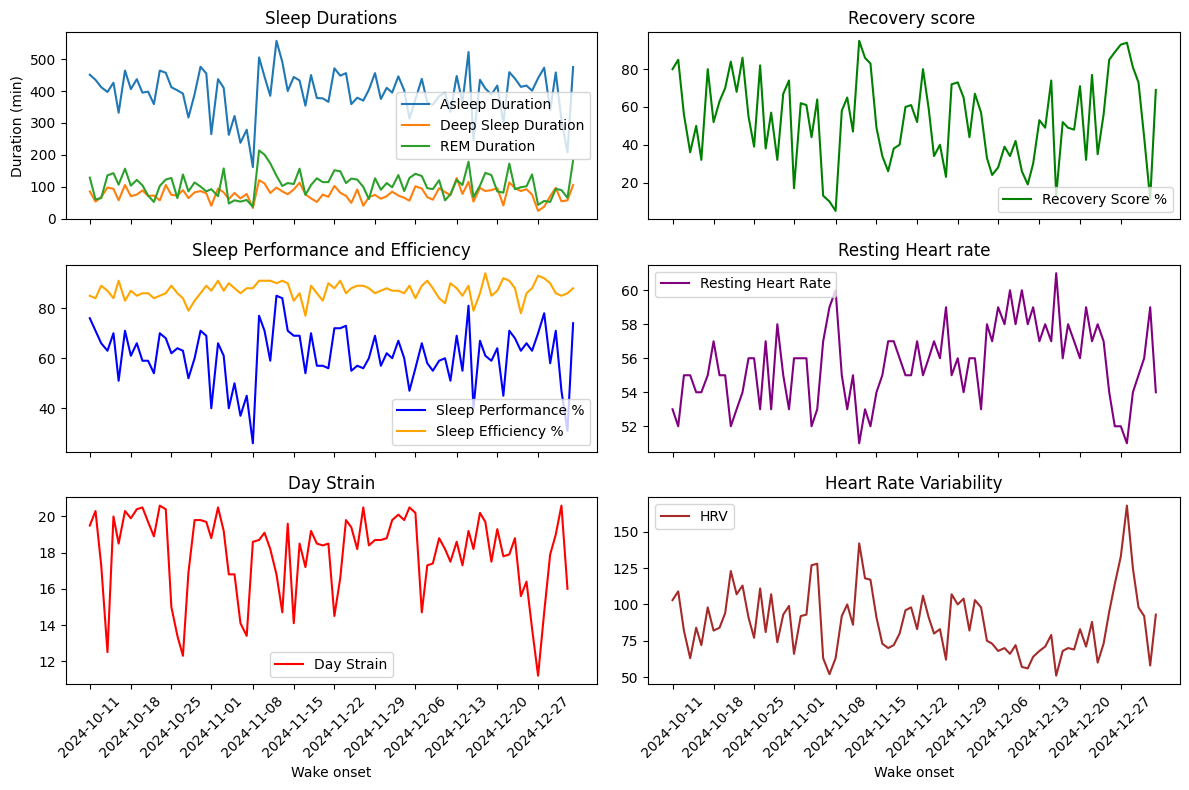

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
xticks = phys["Wake onset"][::7] 

axes[0, 0].plot(phys["Wake onset"], phys["Asleep duration (min)"], label="Asleep Duration")
axes[0, 0].plot(phys["Wake onset"], phys["Deep (SWS) duration (min)"], label="Deep Sleep Duration")
axes[0, 0].plot(phys["Wake onset"], phys["REM duration (min)"], label="REM Duration")
axes[0, 0].set_title("Sleep Durations")
axes[0, 0].legend()
axes[0, 0].set_ylabel("Duration (min)")

axes[0, 1].plot(phys["Wake onset"], phys["Recovery score %"], label="Recovery Score %", color="green")
axes[0, 1].set_title("Recovery score ")
axes[0, 1].legend()

axes[1, 0].plot(phys["Wake onset"], phys["Sleep performance %"], label="Sleep Performance %", color="blue")
axes[1, 0].plot(phys["Wake onset"], phys["Sleep efficiency %"], label="Sleep Efficiency %", color="orange")
axes[1, 0].set_title("Sleep Performance and Efficiency")
axes[1, 0].legend()

axes[1, 1].plot(phys["Wake onset"], phys["Resting heart rate (bpm)"], label="Resting Heart Rate", color="purple")
#axes[1, 1].plot(phys["Cycle start time (day-month)"], phys["Heart rate variability (ms)"], label="HRV", color="brown")
axes[1, 1].set_title("Resting Heart rate")
axes[1, 1].legend()

axes[2, 1].plot(phys["Wake onset"], phys["Heart rate variability (ms)"], label="HRV", color="brown")
axes[2, 1].set_title("Heart Rate Variability")
axes[2, 1].legend()
axes[2, 1].set_xlabel("Wake onset")

axes[2, 0].plot(phys["Wake onset"], phys["Day Strain"], label="Day Strain", color="red")
axes[2, 0].set_title("Day Strain")
axes[2, 0].set_xlabel("Wake onset")
axes[2, 0].legend()

for ax in axes.flatten():
    ax.set_xticks(xticks)  
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()


In these firgures we can see non-stationary data of the different health metrics, we also have a good variety of scores for the different metrics. We can already now see a correlation between our features, especially around early november where there is a significant dip in some of the plots. The removal of some days have introduced a bias and this should be kpet in mind when drawing conclusions. 

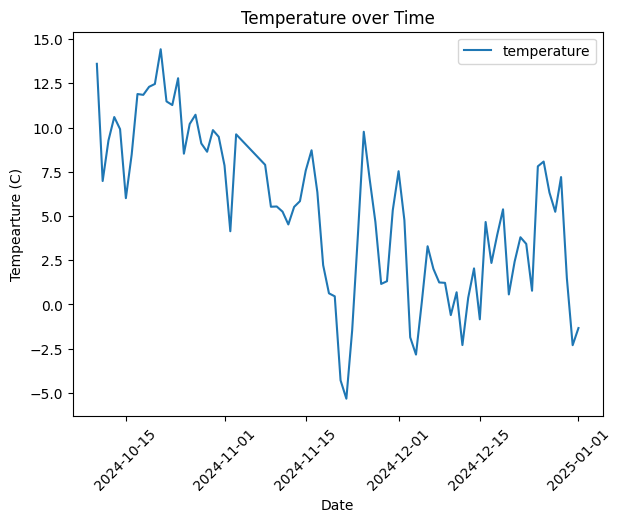

In [3]:
import matplotlib.pyplot as plt

xticks = Temp["Date"][::7] 

plt.plot(Temp["Date"], Temp["Temperature"], label="temperature")
plt.title("Temp")
plt.legend()
plt.title("Temperature over Time")

plt.xlabel("Date")    
plt.ylabel("Tempearture (C)")    
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Here we have the temperature plotted against time and as we can see there is obviously a seasonal trend. I will keep it that way to see if the change in temperature as we are going into a period of winter has an influence on my other features. 

## Merge
In this section we will remove the time component of the wake onset date, rename the wake onset data from the whoop dataset to Date, shift the date back one day and merge with the weather dates. 

In [4]:

# remove time of date
phys["Wake onset"] = phys["Wake onset"].dt.date

# Change change the name to Date
phys.rename(columns={"Wake onset": "Date"}, inplace=True)
# We adjust for the wake up date to align with the day before
phys["Date"] = phys["Date"] - pd.Timedelta(days=1)

# change both to date format
phys["Date"] = pd.to_datetime(phys["Date"])
Temp["Date"] = pd.to_datetime(Temp["Date"])

# Now we merge the dataset with the common column called Date
phys_f = pd.merge(phys, Temp, on="Date", how="outer")
phys_f.head()

,Date,Asleep duration (min),Light sleep duration (min),Deep (SWS) duration (min),REM duration (min),Recovery score %,Resting heart rate (bpm),Heart rate variability (ms),Day Strain,Sleep performance %,Respiratory rate (rpm),Sleep efficiency %,Sleep consistency %,Wake onset formatted,new,Temperature
0,2024-10-10,451.0,236.0,86.0,129.0,80.0,53.0,103.0,19.5,76.0,14.8,85.0,NaN,11-Oct,NaN,13.600000
1,2024-10-11,435.0,320.0,54.0,61.0,85.0,52.0,109.0,20.3,71.0,15.0,84.0,84.0,12-Oct,NaN,6.976923
2,2024-10-12,412.0,279.0,68.0,65.0,56.0,55.0,82.0,17.3,66.0,14.6,89.0,90.0,13-Oct,NaN,9.269231
3,2024-10-13,397.0,163.0,98.0,136.0,36.0,55.0,63.0,12.5,63.0,14.7,87.0,62.0,14-Oct,NaN,10.592308
4,2024-10-14,426.0,189.0,94.0,143.0,50.0,54.0,84.0,20.0,70.0,14.9,84.0,68.0,15-Oct,NaN,9.907692


Now we will move on to plot the correlation between the temperature and our metrics of interest. 

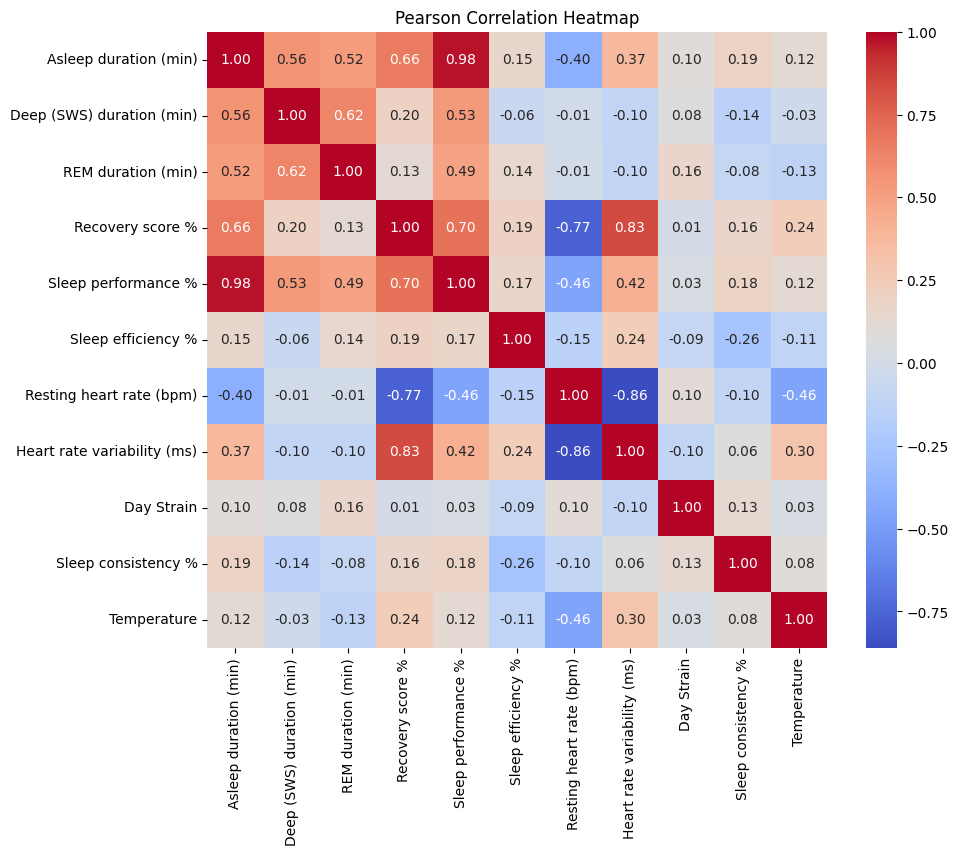

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

columns2 = [
    "Asleep duration (min)",
    "Deep (SWS) duration (min)",
    "REM duration (min)",
    "Recovery score %",
    "Sleep performance %",
    "Sleep efficiency %",
    "Resting heart rate (bpm)",
    "Heart rate variability (ms)",
    "Day Strain",
    "Sleep consistency %",
    "Temperature" 
]
correlation_matrix = phys_f[columns2].corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson Correlation Heatmap")
plt.show()

Correlation is expected through many of these data features, I won't comment on the redudant correlations. Higher recovery scores are strongly associated with a lower resting heart rate, higher heart rate variability, long sleep duration especially when I am paying back sleep debt as reflected in the strong correlation between sleep performance and recovery. While temperature overall influence is weak, a few noteworthy relationships are lower temperature is moderately associated with a higher resting heart rate, whereas a higher temperature is weakly associated with a higher heart rate variability and recovery score. This can perhaps be explained by me underdressing during winter putting pressure on my body to funciton, or perhaps this can be explained by indirect links such as my more sedentary behaviour during winter. Another surprising observation is that we haven't found any association between day strain with any of our other metrics. This can be explained by the low sample size and undoubtably other unmeasured factors at play.

## Wrap up
Analyzing the health data has been a fun exploration and even though I failed to find strong links to the daily temperature I managed to find some links that could be explored more throughly. I have shown the value in merging data from different sources and this will be an interesting exploration to revisit once I have a larger dataset and potentially additional weather features.